# The Perceptron

Let us start by importing some of the libraries we will need and set up our notebook session:

In [211]:
from __future__ import print_function
from __future__ import division

import math

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## A Basic Perceptron

Here goes the blueprint of our perceptron, encoded as a plain Python class, as well as a single auxiliary function. Below we will walk through the details of each code components.

In [212]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

class Perceptron:
    def __init__(self, nb_features=None):
        self.weights = None
        self.nb_features = nb_features # i.e. the nb of incoming connections from other neurons
    
    def set_weights(self, weights=None):
        if weights:
            self.weights = weights
        else:
            self.weights = np.ones(self.nb_features)
    
    def predict(self, feature_vectors, squash=False):
        scores = []
        for fv in feature_vectors:
            s = 0.0
            for i in range(self.nb_features):
                s += self.weights[i] * fv[i]
            scores.append(s)
        
        if squash:
            scores = [sigmoid(v) for v in scores]
        
        return scores

We start by predicting house prices in a really naive way, i.e. we assume that all characteristics are equally important, each having a (positive) weight of 1. We characterize each house along 5 integer variables, namely:
* the number of doors
* surface (in square meters)
* the number of bedrooms
* the number of bathrooms
* its age (in years)

First, we initialize our perceptron, and we specify that we will use 5 input features:

In [213]:
perceptron = Perceptron(nb_features=5)

Next, we set the weights of our perceptron; by default, our perceptron will assign an equal, positive weight of 1.0 to each feature:

In [214]:
perceptron.set_weights()
print(perceptron.weights)

[ 1.  1.  1.  1.  1.]


Now, we create a dummy data set of 5 houses, which are represented as a fixed length vector of five integers (the index of which corresponds to the bullet list above): 

In [215]:
houses = [[2, 3, 5, 1, 8],
          [1, 2, 1, 3, 5],
          [4, 4, 2, 1, 3],
          [11, 6, 8, 9, 8],
          [9, 10, 8, 1, 30]]

In this data set, the last houses have higher a number of doors, bathrooms etc., so that they would have to predict higher prices. We now feed this data set to the `predict()` function of our perceptron (cf. standard `sklearn` naming conventions), and we have it predict a the price for each house:

In [216]:
prices = perceptron.predict(houses)
print(prices)

[19.0, 12.0, 14.0, 42.0, 58.0]


Indeed, the see that for instance the pentultimate house has a relatively higher price. Of course, our feature weighting is now ridiculously naive. Clearly,
* the number of bathrooms should matter relative more than the number of doors
* the age of a house should negatively affect the total price

We can now fix this by setting a more sensible weight vector, which should have five entries (one for each feature). Using these new weights, we should now obtain a more accurate estimate:

In [217]:
weights = [0.5, # doors
           0.9, # surface
           0.8, # bedrooms
           0.9, # bathrooms
           -0.5] # age
perceptron.set_weights(weights)
print(perceptron.predict(houses))

[4.6, 3.3, 6.6, 21.4, 5.799999999999997]


Predicting the price of a house is simple enough and comes down to calculating the **weighted sum** of the feature values. We now see, for instance, that the final house will be valued much less than the pentultimate house in the list, based on the assumption that, while is it much larger, it is also is much older and will therefore require much more investments. Note that the prices predicted are not in an actual currency and vary wildly. In many applications, it is very common to **normalize** the predictions of a perceptron and 'squash' them to a range between 0 and 1. Historically, the **sigmoid** function has often been for this. By setting `squash = True`, we can implement this behaviour in our perceptron:

In [218]:
print(perceptron.predict(houses, squash=True))

[0.9900481981330957, 0.9644288107273639, 0.9986414800495711, 0.9999999994917257, 0.9969815836752917]


We now see that we obtain predictions which are neatly between 0 and 1. In the context of deep learning, functions such as the sigmoid function are often called **activation** functions, because they control how strongly a particular neuron will be activated. In our perceptron, we have a single output neuron, the activation of which is controlled via a sigmoid activation. We call such an activation **element-wise**, is they are applied to each element in a list individually.

## Speeding up our perceptron

The perceptron which we created will be slow, because, right now, it only relies on traditional, unoptimized Python code. Inspect for instance the code block in the `predict()` function above.

The many `for`-loops in this code will make it extremely slow to run. In Deep Learning (and in so many other fields), such code will be too slow to be usable in practice: it is much more common to used **vectorized routines** from specialized libraries, such as `numpy`, which can easily replace our naive `for`-loops. To be able to vectorize our code more efficiently, we will have to convert our Python lists to `numpy` arrays, which essentially are matrix objects, that have a **`shape`** attribute. As will become clear below, the `shape` is an extremely important property of `numpy` arrays, and you will want to keep track of it frequently, e.g.:

In [219]:
houses = np.array(houses)
print(houses.shape)

weights = np.array(weights)
print(weights.shape)

(5, 5)
(5,)


This tells us that our dummy data set is now represented by a two-dimensional matrix which has 5 rows (corresponding to the number of houses) and 5 columns (corresponding to the number of features). Our `weights` variable, on the other hand is a single-dimensional vector, instead of a matrix, of consisting of five numbers (scalars). We are now ready to redefine our Perceptron blueprint to be able to deal with such arrays more efficiently:

In [221]:
def v_sigmoid(x):
    # element-wise; eats any tensor
    return 1 / (1 + np.exp(-x))

class VectorizedPerceptron:
    def __init__(self, nb_features=None):
        self.weights = None
        self.nb_features = nb_features
    
    def set_weights(self, weights=None):
        if isinstance(weights, np.ndarray):
            self.weights = weights
        else:
            self.weights = np.ones(self.nb_features)
    
    def predict(self, feature_vectors, squash=False):
        scores = np.multiply(feature_vectors, self.weights).sum(axis=-1)
        
        if squash:
            scores = v_sigmoid(scores)
        
        return scores

In fact, once you get used to such vectorized notation, vectorized code becomes much easier to read than stacks of for-loops. The result is the same:

In [222]:
v_perceptron = VectorizedPerceptron()
v_perceptron.set_weights(weights)

print(perceptron.predict(houses))
print(perceptron.predict(houses, squash=True))

[4.6, 3.3, 6.6, 21.4, 5.799999999999997]
[0.9900481981330957, 0.9644288107273639, 0.9986414800495711, 0.9999999994917257, 0.9969815836752917]


But is this faster? Let us create an artificial, large house data set to check this:

In [223]:
houses = np.random.uniform(low=-0.05, high=0.05, size=(1000, 500))
print(houses.shape)

(1000, 500)


In [224]:
# simple:
weights = list(np.random.uniform(low=-0.05, high=0.05, size=(500)))
perceptron = Perceptron(nb_features=500)
perceptron.set_weights(weights)

# vectorized:
v_perceptron = VectorizedPerceptron(nb_features=500)
v_perceptron.set_weights(np.array(weights))

Now, we can time the difference:

In [225]:
%timeit perceptron.predict(houses, squash=True)

10 loops, best of 3: 121 ms per loop


In [226]:
%timeit v_perceptron.predict(houses, squash=True)

The slowest run took 4.13 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 655 µs per loop


Jip, it seems to be quite a bit faster -- and believe me, the difference grows even larger for larger data sets. 

## Optimizing the perceptron

Let us implement a pre-historic approach to optimizating our perceptron. We first load the Boston Housing Prices Dataset that ships with `sklearn`:

In [227]:
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target

As you can see, this data set has information for 506 houses across 13 numerical features. The tagret vector which we like to fit is a list of 506 prices associated with each house:

In [228]:
print(X.shape)
print(y.shape)
print(y[:10])

(506, 13)
(506,)
[ 24.   21.6  34.7  33.4  36.2  28.7  22.9  27.1  16.5  18.9]


We start again with a stripped down version of our `Perceptron` class: upon instantiation, objects from this class will create a list of weight parameters, or really small values randomly sampled from a uniform distribution betwee: -0.05 and +0.05:

In [229]:
class Perceptron:
    def __init__(self, nb_features=None):
        np.random.seed(156651)
        self.weights = np.random.uniform(low=-.05, high=0.05,
                                         size=nb_features)
    
    def predict(self, feature_vectors):
        return np.multiply(feature_vectors, self.weights).sum(axis=-1)


Additionally, our `Perceptron` has a `predict` method, which we can use to obtain house prices:

In [230]:
perceptron = Perceptron()
prices = perceptron.predict(X)
print(prices.shape)

(506,)


To be able to measure the current quality of our system, we need a **loss function** or **objective function**: later, we will try to get down the loss returned by the function. As a loss function, we start off with the relatively **mean squared error**: it compares the proces outputted by the system and the **gold standard** (in the `y` vector) and returns the mean of squares with respect to the difference between each predicted price and its gold standard equivalent:

In [231]:
def mean_squared_error(y_gold, y_pred):
    return np.mean((y_gold - y_pred) ** 2)

Let us find out how large the loss for our current model, which has randomly initialized parameters:

In [232]:
preds = perceptron.predict(X)
print(mean_squared_error(preds, y))

4690.98160344


We are now ready to add a naive `fit` method to optimize the parameters of our perceptron. In each **epoch**, we loop over each parameter individually and test two different situations: *hypothesis a*, in which we slightly increase (with a small rate `learning_rate`) and *hypothesis b*, in which we slightly decrease the weight under scrutiny (again with a small `learning` rate). Then, we adjust the parameters in the light of whichever hypothesis gave the best result (i.e. minimized the loss). That goes like this:

In [233]:
class Perceptron:
    def __init__(self, nb_features=None):
        self.nb_features = nb_features
        np.random.seed(156651)
        self.weights = np.array(np.random.uniform(low=-.05, high=0.5,
                                         size=self.nb_features))
    
    def predict(self, feature_vectors, weights=None):
        if not isinstance(weights, np.ndarray):
            return np.multiply(feature_vectors, self.weights).sum(axis=-1)
        else:
            return np.multiply(feature_vectors, weights).sum(axis=-1)
    
    def fit(self, X, y, learning_rate=0.1, nb_epochs=10):
        losses = []
        
        for e in range(nb_epochs):
            for idx in range(self.nb_features):
                # hypothesis a: we increase the parameter:
                weights_plus = self.weights.copy()
                weights_plus[idx] += learning_rate

                # hypothesis b: we increase the parameter:
                weights_minus = self.weights.copy()
                weights_minus[idx] -= learning_rate
                
                # we obtain the predictions for both hypotheses a and b:
                plus_preds = self.predict(X, weights = weights_plus)
                minus_preds = self.predict(X, weights = weights_minus)
                
                # we obtain the predictions for both hypotheses a and b:
                plus_loss = mean_squared_error(plus_preds, y)
                minus_loss = mean_squared_error(minus_preds, y)
                
                # we adjust 
                if plus_loss < minus_loss:
                    self.weights = weights_plus.copy()
                elif minus_loss < plus_loss:
                    self.weights = weights_minus.copy()
            
            # we calculate the loss
            loss = mean_squared_error(self.predict(X), y)
            losses.append(loss)
            
            if e and e % 20 == 0:
                print('Loss after epoch #', e + 1, '->', loss)
        
        return losses

If we now apply this fit method with a small enough learning rate, you see that we are able to gradually push down the loss in the subsequent epoch, until the loss curve staurates and stabilizes:

In [234]:
p = Perceptron(nb_features=X.shape[1])
p.predict(X)
losses = p.fit(X, y, nb_epochs=500, learning_rate=0.001)

Loss after epoch # 21 -> 12810.0791954
Loss after epoch # 41 -> 9000.99965635
Loss after epoch # 61 -> 5880.86619575
Loss after epoch # 81 -> 3449.67881358
Loss after epoch # 101 -> 1707.43750983
Loss after epoch # 121 -> 654.142284513
Loss after epoch # 141 -> 274.257370925
Loss after epoch # 161 -> 157.425433412
Loss after epoch # 181 -> 104.348689457
Loss after epoch # 201 -> 82.9200785025
Loss after epoch # 221 -> 77.8373069622
Loss after epoch # 241 -> 73.1682273692
Loss after epoch # 261 -> 69.6496014858
Loss after epoch # 281 -> 67.0950429085
Loss after epoch # 301 -> 63.9221167168
Loss after epoch # 321 -> 61.674244613
Loss after epoch # 341 -> 59.9468207307
Loss after epoch # 361 -> 58.2859434511
Loss after epoch # 381 -> 57.1467567254
Loss after epoch # 401 -> 56.3005257484
Loss after epoch # 421 -> 55.4604880857
Loss after epoch # 441 -> 54.6421266065
Loss after epoch # 461 -> 53.8346909256
Loss after epoch # 481 -> 53.1350872074


A graphical representation of the loss curve is easy enough to obtain:

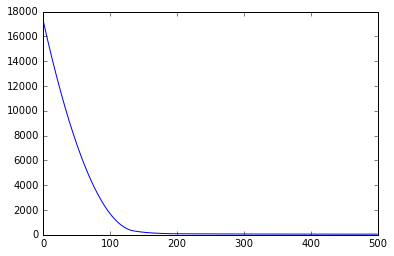

In [235]:
plt.plot(losses)

## Do It Yourself:

Add some simple modifications to the code above. Note that these exercices in fact introduce some key concepts that are very central in modern deep learning research.

* Adapt our Perceptron to show an adaptive, **decreasing learning rate**: after a number of epochs (e.g. 100), it would make sense to decrease the learning steps taken, for instance by a factor of three.
* Implement a form of **early stopping**: stop the training procedure, if the loss doesn't significantly go down anymore for a number of epochs.

## A Perceptron in Theano

Our previous optimization method worked, but was ugly and slow. In this part of the tutorial, we turn to antoher optimization technique that is the main workhorse behind modern representation learning (i.e. gradient descent). We implement the same perceptron as above in **theano**, which is one of the most popular Deep Learning toolkits currently available. We import theano and initialize our random seed:

In [236]:
import theano
import theano.tensor as T # do you know what a tensor is?
rng = np.random
rng.seed(156651)

We begin by instantiating the input matrix which we will use (our X matrix of house features) and the output vector which we could like our model to return, i.e. the list of prices for each house. Both consist of floats, hence the `f` at the beginning of `fmatrix` and `fvector`:

In [237]:
train_input = T.fmatrix('train_input')
train_target = T.fvector('train_output')

What is important is that at this point, both `train_input` and `train_target` are purely **symbolic variables** that don't have an actual value yet. These variables are mere placeholders for when we will actually start using the model. Below, we instantiate our weight metrix containing our parameters. This is not a symbolic variable: it will alreayd have actual values in it, because we initialize it randomly:

In [238]:
weights = np.asarray(rng.uniform(low=-0.05, high=0.05,
                                 size=(X.shape[1])),
                     dtype='float32')
print(weights)
print(weights.shape)

W = theano.shared(value=weights, name='W', borrow=True)

[-0.04963301  0.04475696 -0.02963052 -0.01821073 -0.04093222  0.0021752
  0.03168588 -0.0228706   0.04216252 -0.00994067 -0.01141965 -0.02260192
 -0.01913692]
(13,)


We make use of a theano variable which can 'shared' and 'borrowed', because every component of our code and system will need access to these numbers during the optimization. We make use of 'float32' floating point numbers, because currently those are they only ones -- apart from integers, of course -- which are fully supported on the GPU architectures on which neural networks are typically trained. We are now ready to define the graph which will represent our model. In our case of a plain regression model, the prediction is simple enough:

In [239]:
prediction = (train_input * W).sum(axis=1)

At this point, `prediction` is a mere symbolic variable or a node in the model **graph** we are constructing: to turn into an actual function which we use, we need to **compile** it. In `theano`, we can do that as follows, by specifying both the input and output that this function will need:

In [240]:
predict = theano.function([train_input], prediction)

Did you notice that compiling the graph takes a short while? That is because, under the hood, `theano` will try to optimize a function quite heavily, so that it will be fast to use afterwards. We can now already apply this function:

In [241]:
X = np.array(X, dtype='float32')
predictions = predict(X)
print(predictions.shape)

(506,)


As you can see, we obtain the output vector: its shape already fits our expectations (i.e. a price for each house), but its values will still be worhtless, because our weights are randomly initialized. To find out how well we are currently doing, we need define a function which we can use to measure the cost for a certain state of the model (as we did above), by comparing the current output of the model to the ideal target values which we would have liked to obtain. The cost or objective which we use is, again, the mean squared error. In `theano`, calculating this cost runs largely parallel to the code for `numpy`:

In [242]:
silver_predictions = T.fvector('silver')
gold_predictions = T.fvector('gold')
y = np.array(y, dtype='float32')

cost = T.mean((silver_predictions - gold_predictions) ** 2)

The symbolic `cost` variable too can be compiled into an actual function:

In [243]:
mse = theano.function([silver_predictions, gold_predictions], cost)

When we apply the `mse` function, we see that our cost is huge at this point:

In [244]:
print(mse(predictions, y))

1146.99194336


Let us check whether the output of our theano function is the same as our numpy implementation:

In [245]:
def mean_squared_error(y_gold, y_pred):
    return ((y_gold - y_pred) ** 2).mean()

In [246]:
mean_squared_error(predictions, y)

1146.9921

We are now ready to let the magic happen: in the following block we define a variable that will contain the gradients of our parameters, with respect to the cost function which we defined:

In [247]:
symbolic_cost = T.mean((prediction - train_target) ** 2)
gradients = T.grad(symbolic_cost, W)

Amazingly, we can now check out the current gradients of each of the 13 parameters in our system:

In [248]:
get_grads = theano.function([train_input, train_target], gradients)
print(get_grads(X, y))

[ -1.80837784e+02  -8.57805847e+02  -6.75006226e+02  -5.32577467e+00
  -3.53757362e+01  -4.18336609e+02  -4.28877832e+03  -2.55309296e+02
  -5.72623352e+02  -2.54460781e+04  -1.18703381e+03  -2.40647793e+04
  -7.33394226e+02]


Using these gradients, we don't need to check both hypothesis a and b anymore for the parameters. Moreover, we can make use of the strength of the gradients, allowing for a more flexible update rule. We are now ready to start the optimization process. First, we need to specify a `learning_rate` factor and the number of **epochs** we would to use:

In [249]:
learning_rate = np.float32(0.0000001)
nb_epoch = 500

In 'official' theano, the training function would be something like the following:

In [250]:
updates = [(W, W - np.float32(learning_rate) * gradients)]

train_model = theano.function(
        inputs=[train_input, train_target],
        outputs=symbolic_cost,
        updates=updates,
)

As you can see, we first need to specify an update rule, which will reflect our update mechanism. Then, we compile a function, that takes our `X` and `y` as inputs (`[train_input, train_target]`) and returns the cost (the result of `symbolic`) as a result. Additionally, each time we call this function, our `updates` will be carried out, i.e. the parameters will be adjusted in the light of the respective gradients. We are now ready to launch the model for a number of epochs, and keep track of the -- hopefully decreasing! -- loss in a list:

In [251]:
losses = []
for e in range(nb_epoch):
    c = train_model(X, y)
    print('-> current loss:', c)
    losses.append(c)

-> current loss: 1146.99194336
-> current loss: 1026.00390625
-> current loss: 919.606018066
-> current loss: 826.029541016
-> current loss: 743.720031738
-> current loss: 671.311889648
-> current loss: 607.604858398
-> current loss: 551.544433594
-> current loss: 502.203826904
-> current loss: 458.768859863
-> current loss: 420.523895264
-> current loss: 386.840270996
-> current loss: 357.165405273
-> current loss: 331.013793945
-> current loss: 307.958892822
-> current loss: 287.625732422
-> current loss: 269.684967041
-> current loss: 253.847076416
-> current loss: 239.857681274
-> current loss: 227.493286133
-> current loss: 216.557449341
-> current loss: 206.877593994
-> current loss: 198.302017212
-> current loss: 190.697433472
-> current loss: 183.946746826
-> current loss: 177.947006226
-> current loss: 172.607788086
-> current loss: 167.849578857
-> current loss: 163.602554321
-> current loss: 159.80531311
-> current loss: 156.403930664
-> current loss: 153.350982666
-> curren

Yes! The loss is clearly decreasing and saturates rather quickly. We can graphically inspect the **loss curve** as follows:

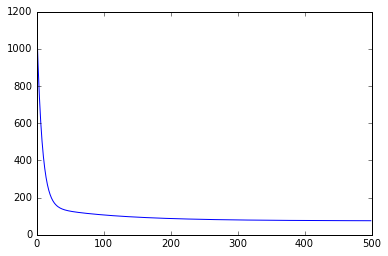

In [252]:
plt.plot(losses)

To make this even more intuitive, we will also implement the update rule ourselves. First, we need to re-initialize our shared variable (to make sure that we start from the same baseline):

In [253]:
rng.seed(156651)
weights = np.asarray(rng.uniform(low=-0.05, high=0.05,
                                 size=(X.shape[1])),
                     dtype='float32')
W.set_value(weights)

Now we start looping and each time we update our parameters in the light of their respective gradients using a simple **update rule**:

In [254]:
losses = []
for e in range(nb_epoch):
    predictions = predict(X)
    curr_loss = mse(predictions, y)
    if e % 50 == 0:
        print('current loss ->', curr_loss)
    losses.append(curr_loss)
    
    # the update mechanism
    curr_grads = get_grads(X, y)
    curr_weights = W.get_value(borrow=True)
    curr_weights = curr_weights - learning_rate * curr_grads # the update rule
    W.set_value(curr_weights)

current loss -> 1146.99194336
current loss -> 127.060585022
current loss -> 106.666549683
current loss -> 94.8662643433
current loss -> 87.4759521484
current loss -> 82.8393249512
current loss -> 79.9231872559
current loss -> 78.0820770264
current loss -> 76.9127578735
current loss -> 76.1633071899


As you can see, we obtain a loss curve that looks very similar to our previous one:

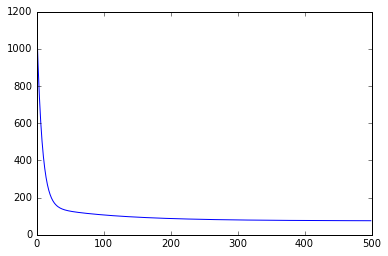

In [255]:
plt.plot(losses)

This should give you an intuition of what it means to do gradient descent and this can be efficiently implemented using a library like Theano.

### DIY

What we implemented above is 'traditional' gradient descent, where we base our gradient updates on loss on the entire dataset at once. In present-day research in representation learning, most data sets are too large too fit in memory, especially if you train networks on GPU which have much more restricted memory capabilities (which sadly compensates their incredible speed). Therefore, scientist nowadays turn to either **stochastic gradient descent** (SGD), where the updates are based on the loss of a smaller sample of the data. Most commonly, people use **minibatch gradient descent**, where each time the loss is calculated for a small random batch of training instances. Common batch sizes range from 30 to 150 (depending on how much data you can fit into memory at once). **Exercise**: implement the SGD training approach with a minibatch size of 25. In each epoch, you should loop over the entire data set in minibatches of 25 training instances from `X` and `y`. Calculate the loss for each batch and update the gradients in the light of the gradients you obtain.

## A Perceptron in TensorFlow

(For the sake of reference, I include a similar implementation of our perceptron in `Tensorflow`, but we probably won't have tim eto work through block by block...)

In [256]:
import tensorflow as tf
import numpy as np

In [257]:
from sklearn.datasets import load_boston
boston = load_boston()
X = boston.data
y = boston.target

X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')

In [258]:
# purely "symbolic variable"
train_input = tf.placeholder(tf.float32, [None, X.shape[1]])

In [259]:
train_output = tf.placeholder(tf.float32, [None])

In [260]:
rng.seed(156651)
weights = tf.Variable(np.asarray(rng.uniform(low=-0.05, high=0.05,
                                 size=(X.shape[1])),
                     dtype='float32'))

In [261]:
model_output = tf.reduce_sum(tf.mul(train_input, weights), 1)

In [262]:
mse_cost = tf.reduce_mean(tf.square(model_output - train_output),
                          reduction_indices=0)

In [263]:
train_step = tf.train.GradientDescentOptimizer(0.0000001).minimize(mse_cost)

In [264]:
init = tf.initialize_all_variables()

In [265]:
sess = tf.Session()
sess.run(init)

In [266]:
f = sess.run(model_output, feed_dict={train_input: X})
print(mean_squared_error(f, y))
g = sess.run(mse_cost, feed_dict={train_input: X, train_output: y})
print(g)

1146.99
1146.99


In [267]:
losses = []
for i in range(500):
    c = sess.run(mse_cost, feed_dict={train_input: X, train_output: y})
    losses.append(c)
    if i % 50 == 0:
        print(c)
    sess.run(train_step, feed_dict={train_input: X, train_output: y})

1146.99
127.061
106.667
94.8663
87.476
82.8393
79.9232
78.0821
76.9128
76.1633


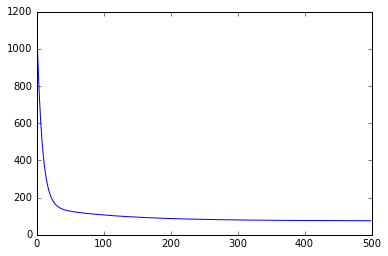

In [268]:
plt.plot(losses)

---------------------------------